# Imports

Let us first call the Python libraries needed here, and upload the needed data and code.

In [2]:
# In case: install missing package(s)
# !pip install rhodium 

# Imports
import rhodium
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import setup, balance_calcs, performance

# Introduction

In this part we will use what we learned from the lake problem to run NSGA-2 with our Conowingo Dam case. Learning to apply a software tool demonstrated in a situation A to the situation B we are interested in is a key engineering skill in today’s world.

The goal here is not to carry out a sophisticated trade-off analysis for the Conowingo Dam, but rather to make sure we know how to run an MOEA with the model we are building. This is why we are focusing on a simple case.

We want to have a policy that restricts withdrawals from the City of Baltimore by a given fraction below a given lake level. We assume that when the restriction kicks in, the city has an alternative water source to ensure continuous supply. We are also interested in lowering the intake level for the nuclear plant.

Decision variables are:

1. The fraction reduction in withdrawals from Baltimore (`reduction`, on a 0-1 range)
3. The depth at which this happens (`reduction_depth`)
4. The depth of the new intake at the nuclear plant (`lower_intake-depth`).

In this tutorial, let us keep objectives simple and have three:

1. Baltimore volumetric reliability (so different values of “reduction” are reflected differently)
2. Reliability of Peach Bottom nuclear plant (we know that’s the same as volumetric reliability: at the nuclear plant when there’s a shortage it’s because the water level is below the intake: then the shortage is 100%).
3. Reliability for the other user with an intake from the reservoir: Chester water supply. How do the proposed policies impact Chester?

# Part 1: Preparation

In this tutorial we build on the model we developed in previous tutorials. Note that because of the way the problem is defined in Rhodium, we need an untouched initial copy of the reservoir (here `conowingo_default`).

In [5]:
# Preparing the model
reservoir_name = 'Conowingo'
downstream_demand_names = ['Environmental']
direct_demand_names = ['Baltimore', 'Chester', 'Nuclear plant']

# Loading the model!
conowingo_default = setup.define_reservoir(reservoir_name, downstream_demand_names, direct_demand_names)

# Read flow and demand data. We keep this copy of the data for the simulation of different futures.
flows_default = setup.extract_flows(reservoir=conowingo_default)

Now we define the planning problem as a function that relates design decisions to performance. Note that here we only simulate the system for 6 years (the driest period) to make it shorter during the tutorial.

In [7]:
def planning_problem(reduction, reduction_depth, lower_intake_depth):
    """
    This function computes desired performance metrics for the decisions given in arguments.

    Arguments:
    reduction: float on [0, 1] range, the reduction in Baltimore water use 
    reduction_depth: float (in m) the amount of water the reservoir can get lower before the restriction kicks in.
                This is a regulation.
    lower_intake: build a new intake for the nuclear plant, at greater depth

    Note that the Reservoir class object and flows pandas DataFrame that are copied are implicit arguments here.

    Outputs are the Baltimore volumetric reliability, nuclear plant reliability, and Chester water supply reliability.

    Note we are focusing on the few dry years in the 1960s to make runtime shorter.
    """

    # Get copies of the data so that there is an untouched original copy
    time_mask = (flows_default.index.year > 1961) & (flows_default.index.year < 1968)
    water_balance = flows_default.iloc[time_mask, :].copy()
    reservoir = copy.deepcopy(conowingo_default)

    # Define the reduction that kicks in like a new demand
    reservoir.add_on_site_demand(setup.Demand('Baltimore 2', reduction_depth))

    # Split Baltimore demand into two: the fraction immune to reductions and the one hit by it.
    total_baltimore_demand = water_balance.sum(axis=0)['Baltimore demand (m3/s)']
    water_balance['Baltimore 2 demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * reduction
    water_balance['Baltimore demand (m3/s)'] = water_balance['Baltimore demand (m3/s)'] * (1-reduction)

    # Lower the intake for the nuclear plant
    reservoir.demand_on_site[2].intake_depth = lower_intake_depth

    # Computing the water balance for our standard operating policy (SOP)
    balance_calcs.sop_full(reservoir=reservoir, water_flows=water_balance)

    # We compute performance indicators
    # Baltimore volumetric reliability
    total_baltimore_withdrawals = water_balance.sum(axis=0)['Withdrawals Baltimore (m3/s)'] + water_balance.sum(axis=0)['Withdrawals Baltimore 2 (m3/s)']
    baltimore_vol_rel = total_baltimore_withdrawals / total_baltimore_demand
    # Nuclear plant reliability
    nuclear_rel = performance.reliability(water_balance['Withdrawals Nuclear plant (m3/s)'], water_balance['Nuclear plant demand (m3/s)'], True)
    # Chester reliability
    chester_rel = performance.reliability(water_balance['Withdrawals Chester (m3/s)'], water_balance['Chester demand (m3/s)'], True)

    return baltimore_vol_rel, nuclear_rel, chester_rel

In [8]:
# Note what happens when we call the function
default_perf = planning_problem(0, 0, conowingo_default.demand_on_site[2].intake_depth)
print('Without intervention, in 1962-1967 Baltimore volumetric reliability is ' + "{:.2f}".format(default_perf[0]) + ',')
print('the nuclear plant reliability is ' + "{:.2f}".format(default_perf[1]) + ',')
print('and water supply reliability for Chester is ' + "{:.2f}".format(default_perf[2]) + '.')

Without intervention, in 1962-1967 Baltimore volumetric reliability is 0.93,
the nuclear plant reliability is 0.81,
and water supply reliability for Chester is 0.84.


# Part 2: Running Rhodium

Note how we are adapting the Rhodium tutorial code to our problem. We define:
* The model.
* Parameters which here coincide with the decisions (a.k.a levers).
* Responses which are the performance metrics, and how we minimise or maximise them.

In [10]:
# Let us now define the model for the Rhodium library
conowingo_model = rhodium.Model(planning_problem)

conowingo_model.parameters = [rhodium.Parameter('reduction'),
                              rhodium.Parameter('reduction_depth'),
                              rhodium.Parameter('lower_intake_depth')]

conowingo_model.levers = [rhodium.RealLever('reduction', 0.0, 0.5),
                          rhodium.RealLever('reduction_depth', 0.0, conowingo_default.demand_on_site[0].intake_depth), 
                          rhodium.RealLever('lower_intake_depth', conowingo_default.demand_on_site[2].intake_depth, 
                                               conowingo_default.demand_on_site[0].intake_depth)]  # Intake lower than before, no lower than Baltimore intake

conowingo_model.responses = [rhodium.Response('baltimore_vol_rel', rhodium.Response.MAXIMIZE),
                             rhodium.Response('nuclear_rel', rhodium.Response.MAXIMIZE),
                             rhodium.Response('chester_rel', rhodium.Response.MAXIMIZE)]

In [11]:
# Optimize
output = rhodium.optimize(conowingo_model, 'NSGAII', 2000)
print("Found", len(output), "optimal policies!")

Found 100 optimal policies!


In [12]:
print(output)

Index 0:
    reduction: 0.39120142796512763
    reduction_depth: 5.174657720954433
    lower_intake_depth: 4.823412165961513
    baltimore_vol_rel: 0.9274303970789592
    nuclear_rel: 0.9091738931994523
    chester_rel: 0.8384299406663624
Index 1:
    reduction: 0.4997551491834236
    reduction_depth: 0.006221968317824518
    lower_intake_depth: 2.294154517052516
    baltimore_vol_rel: 0.8581039596315657
    nuclear_rel: 0.8525787311729804
    chester_rel: 0.8575992697398448
Index 2:
    reduction: 0.00011639861267084828
    reduction_depth: 0.5224978154946164
    lower_intake_depth: 1.591679417646574
    baltimore_vol_rel: 0.9301517661555089
    nuclear_rel: 0.8174349612049292
    chester_rel: 0.8393427658603377
Index 3:
    reduction: 0.4724141442883523
    reduction_depth: 0.04717335562785981
    lower_intake_depth: 5.172542717115077
    baltimore_vol_rel: 0.8643320741821825
    nuclear_rel: 0.956184390689183
    chester_rel: 0.8553172067549064
Index 4:
    reduction: 0.256639020550

# Part 3: Visualising results

We have a list of Pareto front solutions, with decision variables and the metrics they lead to. We can plot them using examples from the lake problem.

C:\Users\ci1cjr\AppData\Local\anaconda3\envs\mac441\Lib\site-packages\rhodium\plot.py:811: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = df_min[i] if model.responses[df.columns.values[i]].dir == Response.MINIMIZE else df_max[i]
C:\Users\ci1cjr\AppData\Local\anaconda3\envs\mac441\Lib\site-packages\rhodium\plot.py:827: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = df_max[i] if model.responses[df.columns.values[i]].dir == Response.MINIMIZE else df_min[i]


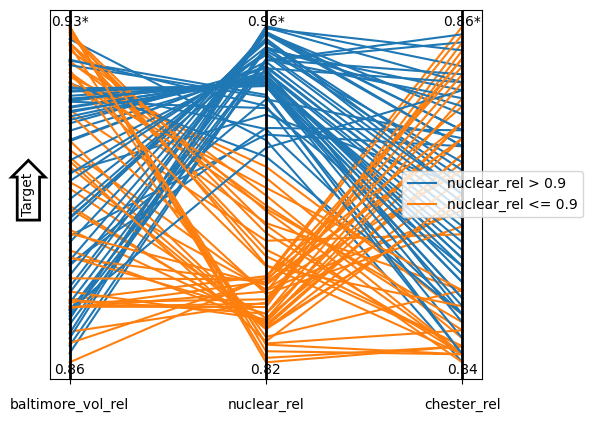

In [14]:
# Figures that look fancy in one place sometimes are not so easy to reproduce somewhere else.
# But as long as the errors don't prevent the plotting.
fig = rhodium.parallel_coordinates(conowingo_model, output, brush=[rhodium.Brush("nuclear_rel > 0.9"), rhodium.Brush("nuclear_rel <= 0.9")])

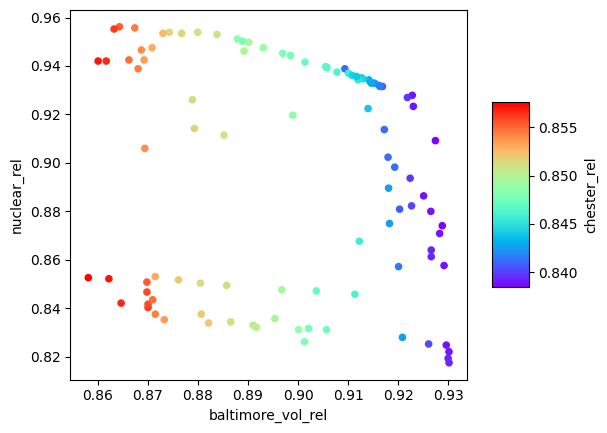

In [15]:
fig = rhodium.scatter2d(conowingo_model, output, c='chester_rel')

**Rhodium examples only look at optimization objectives! What if we want to relate them to decision variables.**

In [17]:
# We can save the output in DataFrame format
output_df = output.as_dataframe()
display(output_df)

,reduction,reduction_depth,lower_intake_depth,baltimore_vol_rel,nuclear_rel,chester_rel
0,0.391201,5.174658,4.823412,0.927430,0.909174,0.838430
1,0.499755,0.006222,2.294155,0.858104,0.852579,0.857599
2,0.000116,0.522498,1.591679,0.930152,0.817435,0.839343
3,0.472414,0.047173,5.172543,0.864332,0.956184,0.855317
4,0.256639,0.132820,4.613069,0.898963,0.919671,0.848471
...,...,...,...,...,...,...
95,0.000191,0.368877,1.735670,0.930139,0.821999,0.838886
96,0.120628,0.676385,5.160792,0.916367,0.931538,0.841625
97,0.435671,0.045823,1.864131,0.871476,0.837517,0.854404
98,0.282147,0.320467,5.158790,0.896940,0.945230,0.848015


Text(0, 0.5, 'Baltimore volumetric reliability')

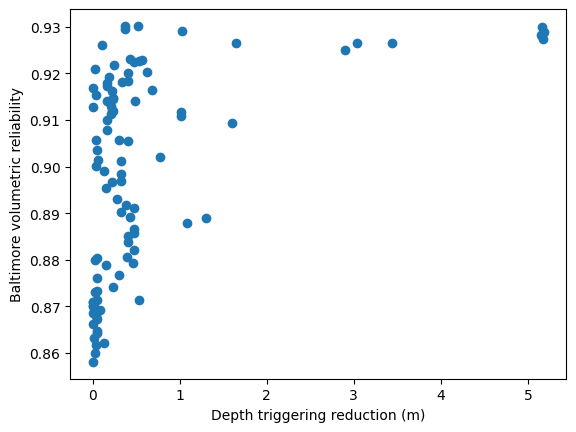

In [18]:
plt.scatter(output_df['reduction_depth'], output_df['baltimore_vol_rel'])
plt.xlabel('Depth triggering reduction (m)')
plt.ylabel('Baltimore volumetric reliability')

Text(0, 0.5, 'Baltimore volumetric reliability')

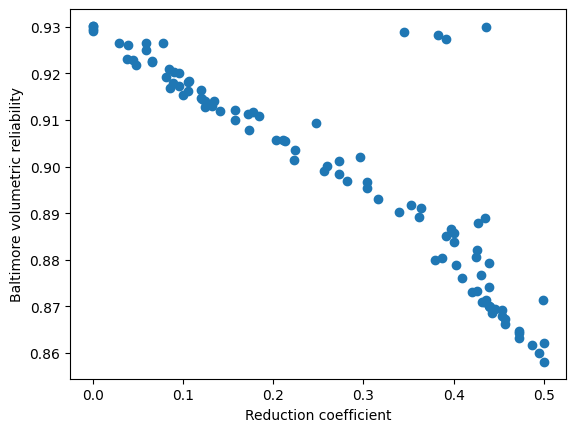

In [19]:
plt.scatter(output_df['reduction'], output_df['baltimore_vol_rel'])
plt.xlabel('Reduction coefficient')
plt.ylabel('Baltimore volumetric reliability')

Text(0, 0.5, 'Baltimore volumetric reliability')

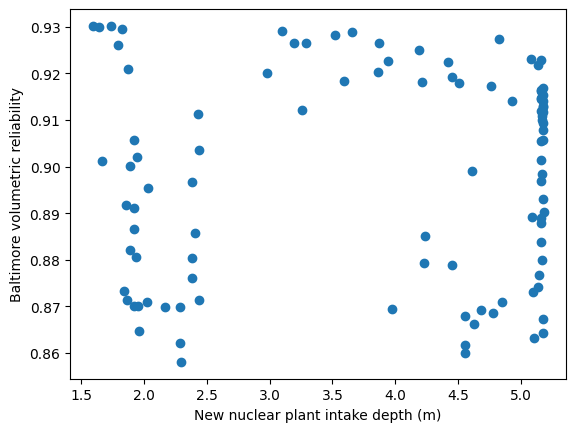

In [20]:
plt.scatter(output_df['lower_intake_depth'], output_df['baltimore_vol_rel'])
plt.xlabel('New nuclear plant intake depth (m)')
plt.ylabel('Baltimore volumetric reliability')

Text(0, 0.5, 'Nuclear plant water supply reliability')

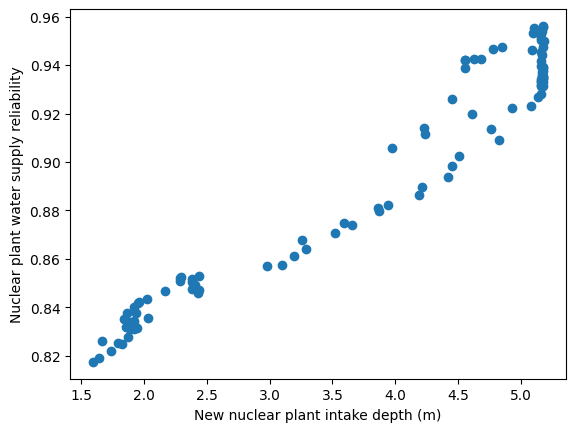

In [21]:
plt.scatter(output_df['lower_intake_depth'], output_df['nuclear_rel'])
plt.xlabel('New nuclear plant intake depth (m)')
plt.ylabel('Nuclear plant water supply reliability')

>* **Question 1. What do we learn about the trade-offs between the different demands?**
>* **Question 2. What do we learn about how design choices affect performance?**

On trade-offs:
* Clear trade-off between Baltimore and Chester but chosen decision have little impact on Chester reliability.
* Trade-off between nuclear plant and Baltimore much more unclear, but large range of outcomes for both.
* It could be worth it re-running the simulations with only two objectives (Baltimore and nuclear plant), and check impact on Chester is minor for selected solution.

On connections between design choices and performance:
* The reduction coefficient is a key determinant of Baltimore volumetric reliability.
* The new intake depth for the nuclear plant does not affect Baltimore much, because nuclear plant withdrawal volumes are comparatively small. But a deeper intake is key for the nuclear plant. 
* Overall different decisions affect the users almost independently. The current setup does not enable one to evaluate how e.g., Baltimore related decisions affect the nuclear plant.